In [16]:
import numpy as np
import matplotlib
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

In [17]:
from astropy.io import fits
fits_image_filename = '../Data/fits/calexp-1-136326.fits'

hdu_list = fits.open(fits_image_filename)

In [18]:
image_data = fits.getdata(fits_image_filename,0)
print(type(image_data))
print(image_data.shape)

<class 'numpy.ndarray'>
(6132, 8176)


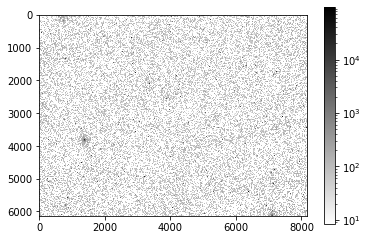

In [19]:
plt.imshow(image_data,cmap='gray_r',norm=LogNorm())
plt.colorbar()

In [20]:
from astropy.convolution import Gaussian2DKernel
from photutils import Background2D, MedianBackground
from photutils import detect_threshold, detect_sources
data = image_data
bkg_estimator = MedianBackground()
bkg = Background2D(data, (50, 50), filter_size=(3, 3), bkg_estimator=bkg_estimator)
threshold = bkg.background + (10. * bkg.background_rms)

In [21]:
from astropy.stats import gaussian_fwhm_to_sigma
sigma = 3.0 * gaussian_fwhm_to_sigma  # FWHM = 3.
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()
npixels = 5
segm = detect_sources(data, threshold, npixels=npixels,filter_kernel=kernel)
#segm_deblend = deblend_sources(data, segm, npixels=npixels,filter_kernel=kernel, nlevels=32,contrast=0.001)

In [22]:
from photutils import source_properties
cat = source_properties(data, segm)
tbl = cat.to_table()
tbl['xcentroid'].info.format = '.2f'
tbl['ycentroid'].info.format = '.2f'
tbl['ellipticity'].info.format = '.2f'
tbl['equivalent_radius'].info.format = '.2f'
print(tbl)

 id  xcentroid ycentroid ...         cyy                 gini       
        pix       pix    ...       1 / pix2                         
---- --------- --------- ... ------------------- -------------------
   1   8170.68      1.38 ...  0.8649557803497242  0.4743500139781945
   2   5534.93      4.19 ...   0.785970358071599  0.4460456701383804
   3   8116.53      6.85 ...  0.3427651428734173 0.26166118621361645
   4   7692.77      8.23 ...  0.4378250488372188  0.4258354151631234
   5   5260.31     10.31 ...    1.14226567518765  0.2774111270524478
   6   5958.99      9.71 ...   2.074712254429123 0.17203983458519773
   7   1061.80     13.62 ...   4.662833047032479 0.03051643192488274
   8   7903.09     18.15 ...  0.3156050450136545  0.5302576578998854
   9    813.76     20.39 ...  0.5377102042367432  0.6275235544889832
  10   8159.11     23.51 ...  0.2259482249800085  0.6093541850889812
 ...       ...       ... ...                 ...                 ...
5352   1841.89   6119.64 ...  0.65

In [42]:
print(source_properties(data,segm).ycentroid.value)


[1.37995352e+00 4.18608479e+00 6.84893048e+00 ... 6.12538487e+03
 6.13053108e+03 6.13100000e+03]


In [37]:
darray = np.asarray([source_properties(data,segm).xcentroid.value,source_properties(data,segm).ycentroid.value,source_properties(data,segm).elongation.value,source_properties(data,segm).equivalent_radius.value])
print(darray)
print(darray.shape)






[[8.17068307e+03 5.53492638e+03 8.11652581e+03 ... 1.05595408e+03
  4.20928817e+03 1.28000000e+03]
 [1.37995352e+00 4.18608479e+00 6.84893048e+00 ... 6.12538487e+03
  6.13053108e+03 6.13100000e+03]
 [1.70273092e+00 2.60326596e+00 2.46259389e+00 ... 1.86632905e+00
  1.60589584e+00 1.00000000e+00]
 [3.69963851e+00 4.06842895e+00 4.51351667e+00 ... 2.76395320e+00
  2.45924538e+00 1.38197660e+00]]
(4, 5361)


In [41]:
import pandas as pd
df = pd.DataFrame(data=darray.T,columns = ['xcentroid','ycentroid','elongation','equivalent radius'])
print(df)

        xcentroid    ycentroid  elongation  equivalent radius
0     8170.683066     1.379954    1.702731           3.699639
1     5534.926384     4.186085    2.603266           4.068429
2     8116.525808     6.848930    2.462594           4.513517
3     7692.768806     8.230611    2.745266           4.918491
4     5260.310856    10.306392    2.797919           3.141275
...           ...          ...         ...                ...
5356  2107.480239  6126.997243    1.375996           6.333012
5357  5830.385013  6124.449397    1.555058           2.646284
5358  1055.954078  6125.384873    1.866329           2.763953
5359  4209.288174  6130.531078    1.605896           2.459245
5360  1280.000000  6131.000000    1.000000           1.381977

[5361 rows x 4 columns]


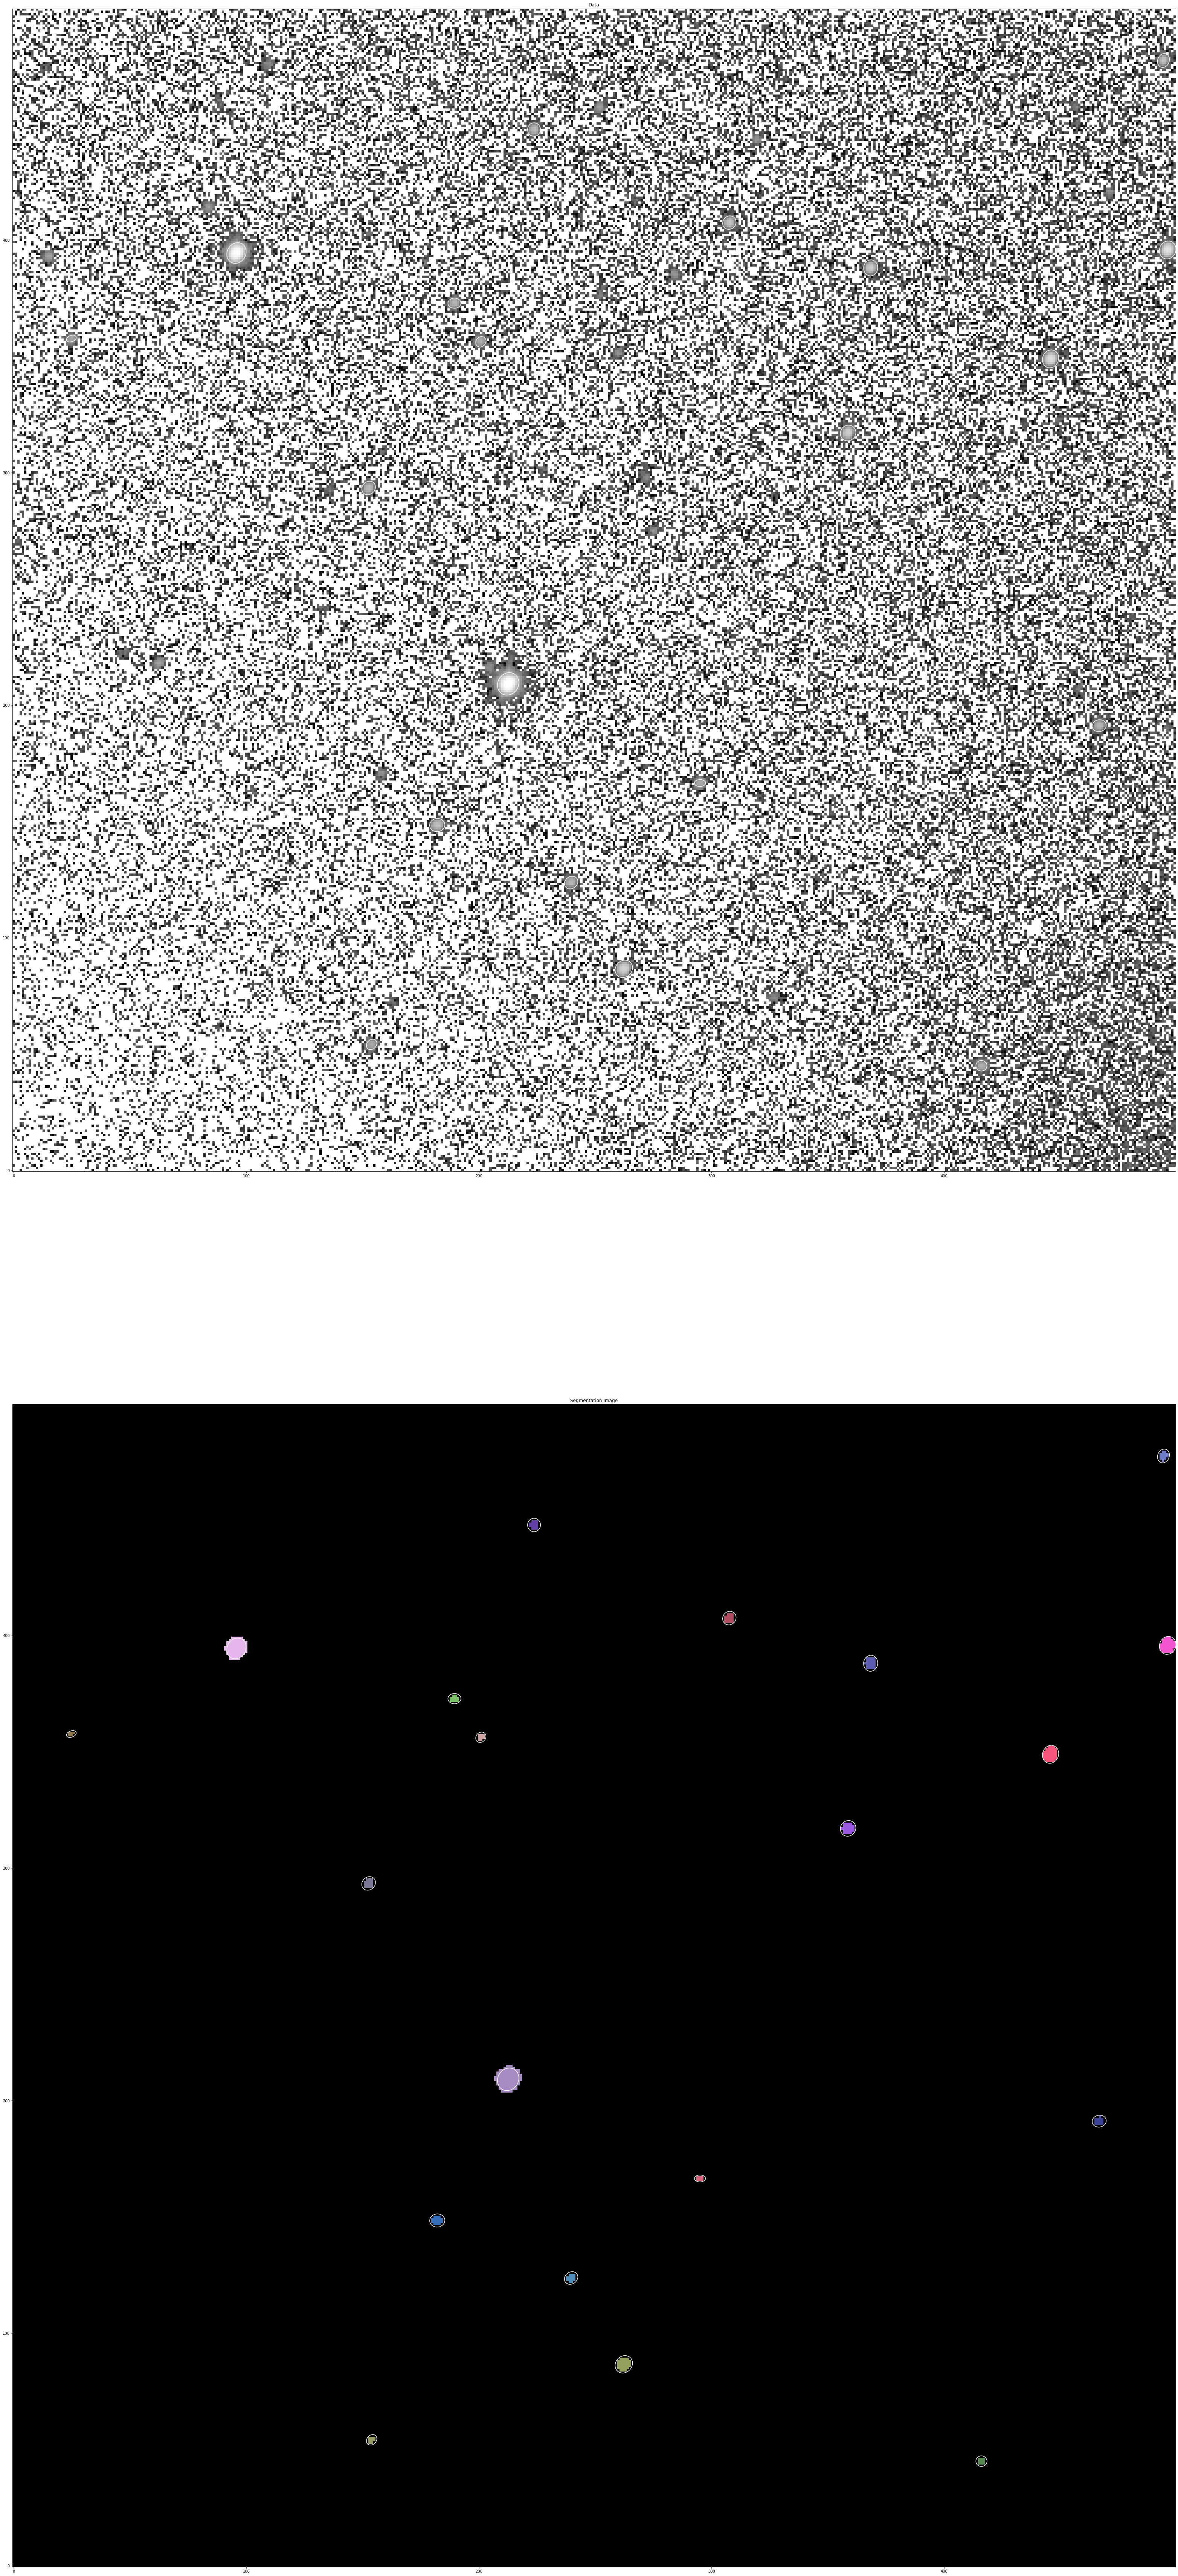

In [14]:
data = image_data[:500,:500]
bkg_estimator = MedianBackground()
bkg = Background2D(data, (50, 50), filter_size=(3, 3), bkg_estimator=bkg_estimator)
threshold = bkg.background + (10. * bkg.background_rms)
sigma = 3.0 * gaussian_fwhm_to_sigma  # FWHM = 3.
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()
npixels = 5
segm = detect_sources(data, threshold, npixels=npixels,filter_kernel=kernel)
cat = source_properties(data, segm)
r = 3.  # approximate isophotal extent
apertures = []
for obj in cat:
    position = np.transpose((obj.xcentroid.value, obj.ycentroid.value))
    a = obj.semimajor_axis_sigma.value * r
    b = obj.semiminor_axis_sigma.value * r
    theta = obj.orientation.to(u.rad).value
    apertures.append(EllipticalAperture(position, a, b, theta=theta))

norm = ImageNormalize(stretch=SqrtStretch())
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(100, 125))
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=LogNorm())
ax1.set_title('Data')
cmap = segm.make_cmap(random_state=12345)
ax2.imshow(segm, origin='lower', cmap=cmap)
ax2.set_title('Segmentation Image')
for aperture in apertures:
    aperture.plot(axes=ax1, color='white', lw=1.5)
    aperture.plot(axes=ax2, color='white', lw=1.5)